In [1]:
import sys
sys.path.append('../')
import glob2 as glob
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
%matplotlib inline

from sklearn import preprocessing
import warnings; warnings.simplefilter('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_val_score
SEED = 17

In [3]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import svm

In [4]:
features_heroes = {
                    '1hero_id',
                    '2hero_id',
                    '3hero_id',
                    '4hero_id',
                    '5hero_id',
                    '6hero_id',
                    '7hero_id',
                    '8hero_id',
                    '9hero_id',
                    '10hero_id',
                    '11hero_id',
                    '12hero_id',
                    '13hero_id',
                    '14hero_id',
                    '15hero_id',
                    '16hero_id',
                    '17hero_id',
                    '18hero_id',
                    '19hero_id',
                    '20hero_id',
                    '21hero_id',
                    '22hero_id'
}

In [18]:
train_features = pd.read_csv('data2/dpc_train_features.csv', index_col='match_id')
test_features = pd.read_csv('data2/dpc_test_features.csv', index_col='match_id')
train_targets = pd.read_csv('data2/dpc_train_target.csv', index_col='match_id')
test_targets = pd.read_csv('data2/dpc_test_target.csv', index_col='match_id')

In [19]:
#train_targets = train_targets['radiant_win'].values
#test_targets = test_targets['radiant_win'].values

In [20]:
#X_remainder = train_features
#y_remainder = train_targets
#X_test = test_features
#y_test = test_targets

In [21]:
#X_remainder.shape, y_remainder.shape, X_test.shape, y_test.shape

In [22]:
# Combining training and test features for convenience so I can hot encode both at same time
all_features = pd.concat([train_features, test_features])

# Index to split the training and test data sets
idx_split = train_features.shape[0]

In [23]:
for i in range(1,23):
        all_features = pd.get_dummies(all_features, columns = [f'{i}hero_id'])

print(all_features.shape)

(1162, 2088)


In [24]:
# Encoded train/test features

X_remainder = all_features[:idx_split]
X_test = all_features[idx_split:]

y_remainder = train_targets['radiant_win'].values
y_test = test_targets['radiant_win'].values

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size = 0.1, random_state = SEED) ## see top, SEED = 17

# Model w Hot Encoding
Try Random Forest with hot encoding (i.e., with just the stock label encoding)

Following along with 

https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb

In [26]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

In [27]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_valid, [1 for _ in range(len(y_valid))])
    baseline['precision'] = precision_score(y_valid, [1 for _ in range(len(y_valid))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_valid, predictions)
    results['precision'] = precision_score(y_valid, predictions)
    results['roc'] = roc_auc_score(y_valid, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_valid, [1 for _ in range(len(y_valid))])
    model_fpr, model_tpr, _ = roc_curve(y_valid, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [28]:
from sklearn.ensemble import RandomForestClassifier
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=SEED, 
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=17, verbose=1,
                       warm_start=False)

In [29]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 543
Average maximum depth 95


In [30]:
# # 30% examples in test data
#train, test, train_labels, test_labels = train_test_split(df, labels, 
#                                                          stratify = labels,
#                                                          test_size = 0.3, 
#                                                          random_state = RSEED)

# NOTE example lables as train, test, train_labels, test_labels

In [31]:
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

rf_predictions = model.predict(X_valid)
rf_probs = model.predict_proba(X_valid)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Recall Baseline: 1.0 Test: 0.43 Train: 1.0
Precision Baseline: 0.44 Test: 0.34 Train: 1.0
Roc Baseline: 0.5 Test: 0.38 Train: 1.0


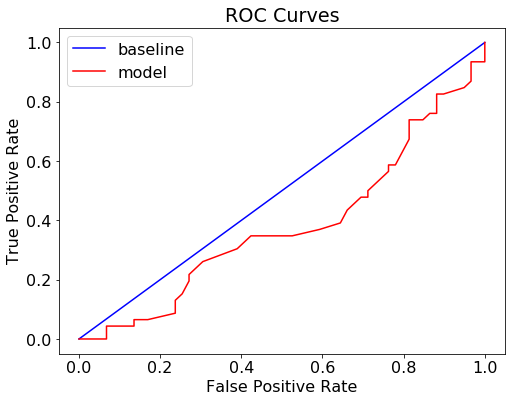

In [32]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [33]:
from sklearn.metrics import confusion_matrix
import itertools
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=['Radiant Lose','Radiant Win'],
#                      title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[20 39]
 [26 20]]


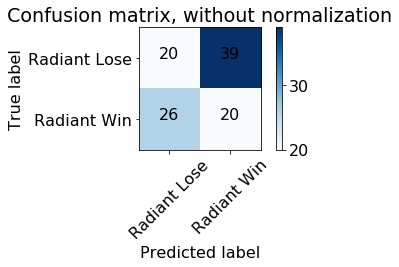

In [34]:
# Compute confusion matrix
cm = confusion_matrix(y_valid, rf_predictions)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['Radiant Lose','Radiant Win'],
                      title='Confusion matrix, without normalization')

Feature Importance

In [35]:
# Lookup where features was defined
# Features for feature importances
features = list(X_remainder.columns)

fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
78,1hero_id_68,0.003968
1021,12hero_id_106,0.003608
1259,15hero_id_7,0.003208
829,11hero_id_17,0.003034
149,2hero_id_66,0.002923
1923,21hero_id_52,0.002877
221,3hero_id_65,0.002709
101,1hero_id_97,0.002657
226,3hero_id_72,0.002642
383,5hero_id_79,0.002551


### Optimization through random search
Optimization through random search

In [36]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = SEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 5, 
                        n_iter = 10, verbose = 1, random_state=SEED)

# Fit 
rs.fit(X_remainder, y_remainder)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   52.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [37]:
rs.best_params_

{'n_estimators': 37,
 'min_samples_split': 5,
 'max_leaf_nodes': 37,
 'max_features': 0.7999999999999999,
 'max_depth': 17,
 'bootstrap': False}

Using the best model

In [38]:
best_model = rs.best_estimator_

In [39]:
train_rf_predictions_best = best_model.predict(X_remainder)
train_rf_probs_best = best_model.predict_proba(X_remainder)[:, 1]

rf_predictions_best = best_model.predict(X_test)
rf_probs_best = best_model.predict_proba(X_test)[:, 1]

In [40]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 73
Average maximum depth 17


In [41]:
def evaluate_model1(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_remainder, train_predictions)
    train_results['precision'] = precision_score(y_remainder, train_predictions)
    train_results['roc'] = roc_auc_score(y_remainder, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.15 Train: 0.3
Precision Baseline: 0.46 Test: 0.89 Train: 0.96
Roc Baseline: 0.5 Test: 0.55 Train: 0.76


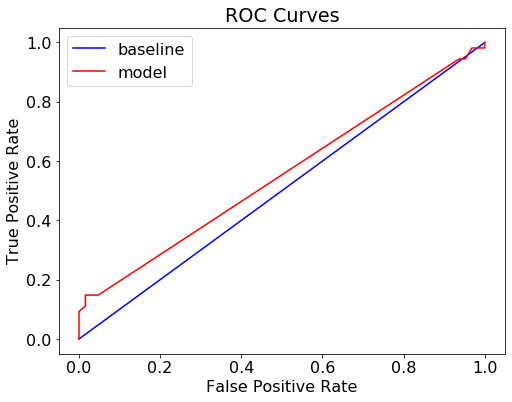

In [42]:
evaluate_model1(rf_predictions_best, rf_probs_best, train_rf_predictions_best, train_rf_probs_best)

In [59]:
best_model.score(X_test,y_test)

0.5982905982905983

In [61]:
print(classification_report(y_test, rf_predictions_best))

              precision    recall  f1-score   support

           0       0.57      0.98      0.73        63
           1       0.89      0.15      0.25        54

    accuracy                           0.60       117
   macro avg       0.73      0.57      0.49       117
weighted avg       0.72      0.60      0.51       117



In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
estimator = best_model.estimators_[1]

# Export a tree from the forest
# export as dot
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=X_remainder.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

In [50]:
!dot -Tpng tree_from_optimized_forest.dot -o tree_from_optimized_forest.png

Error: tree_from_optimized_forest.dot: syntax error in line 1 near '�PNG'


In [54]:
#from subprocess import call
# Convert to png
#call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.dot', '-Gdpi=200'])

#call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])


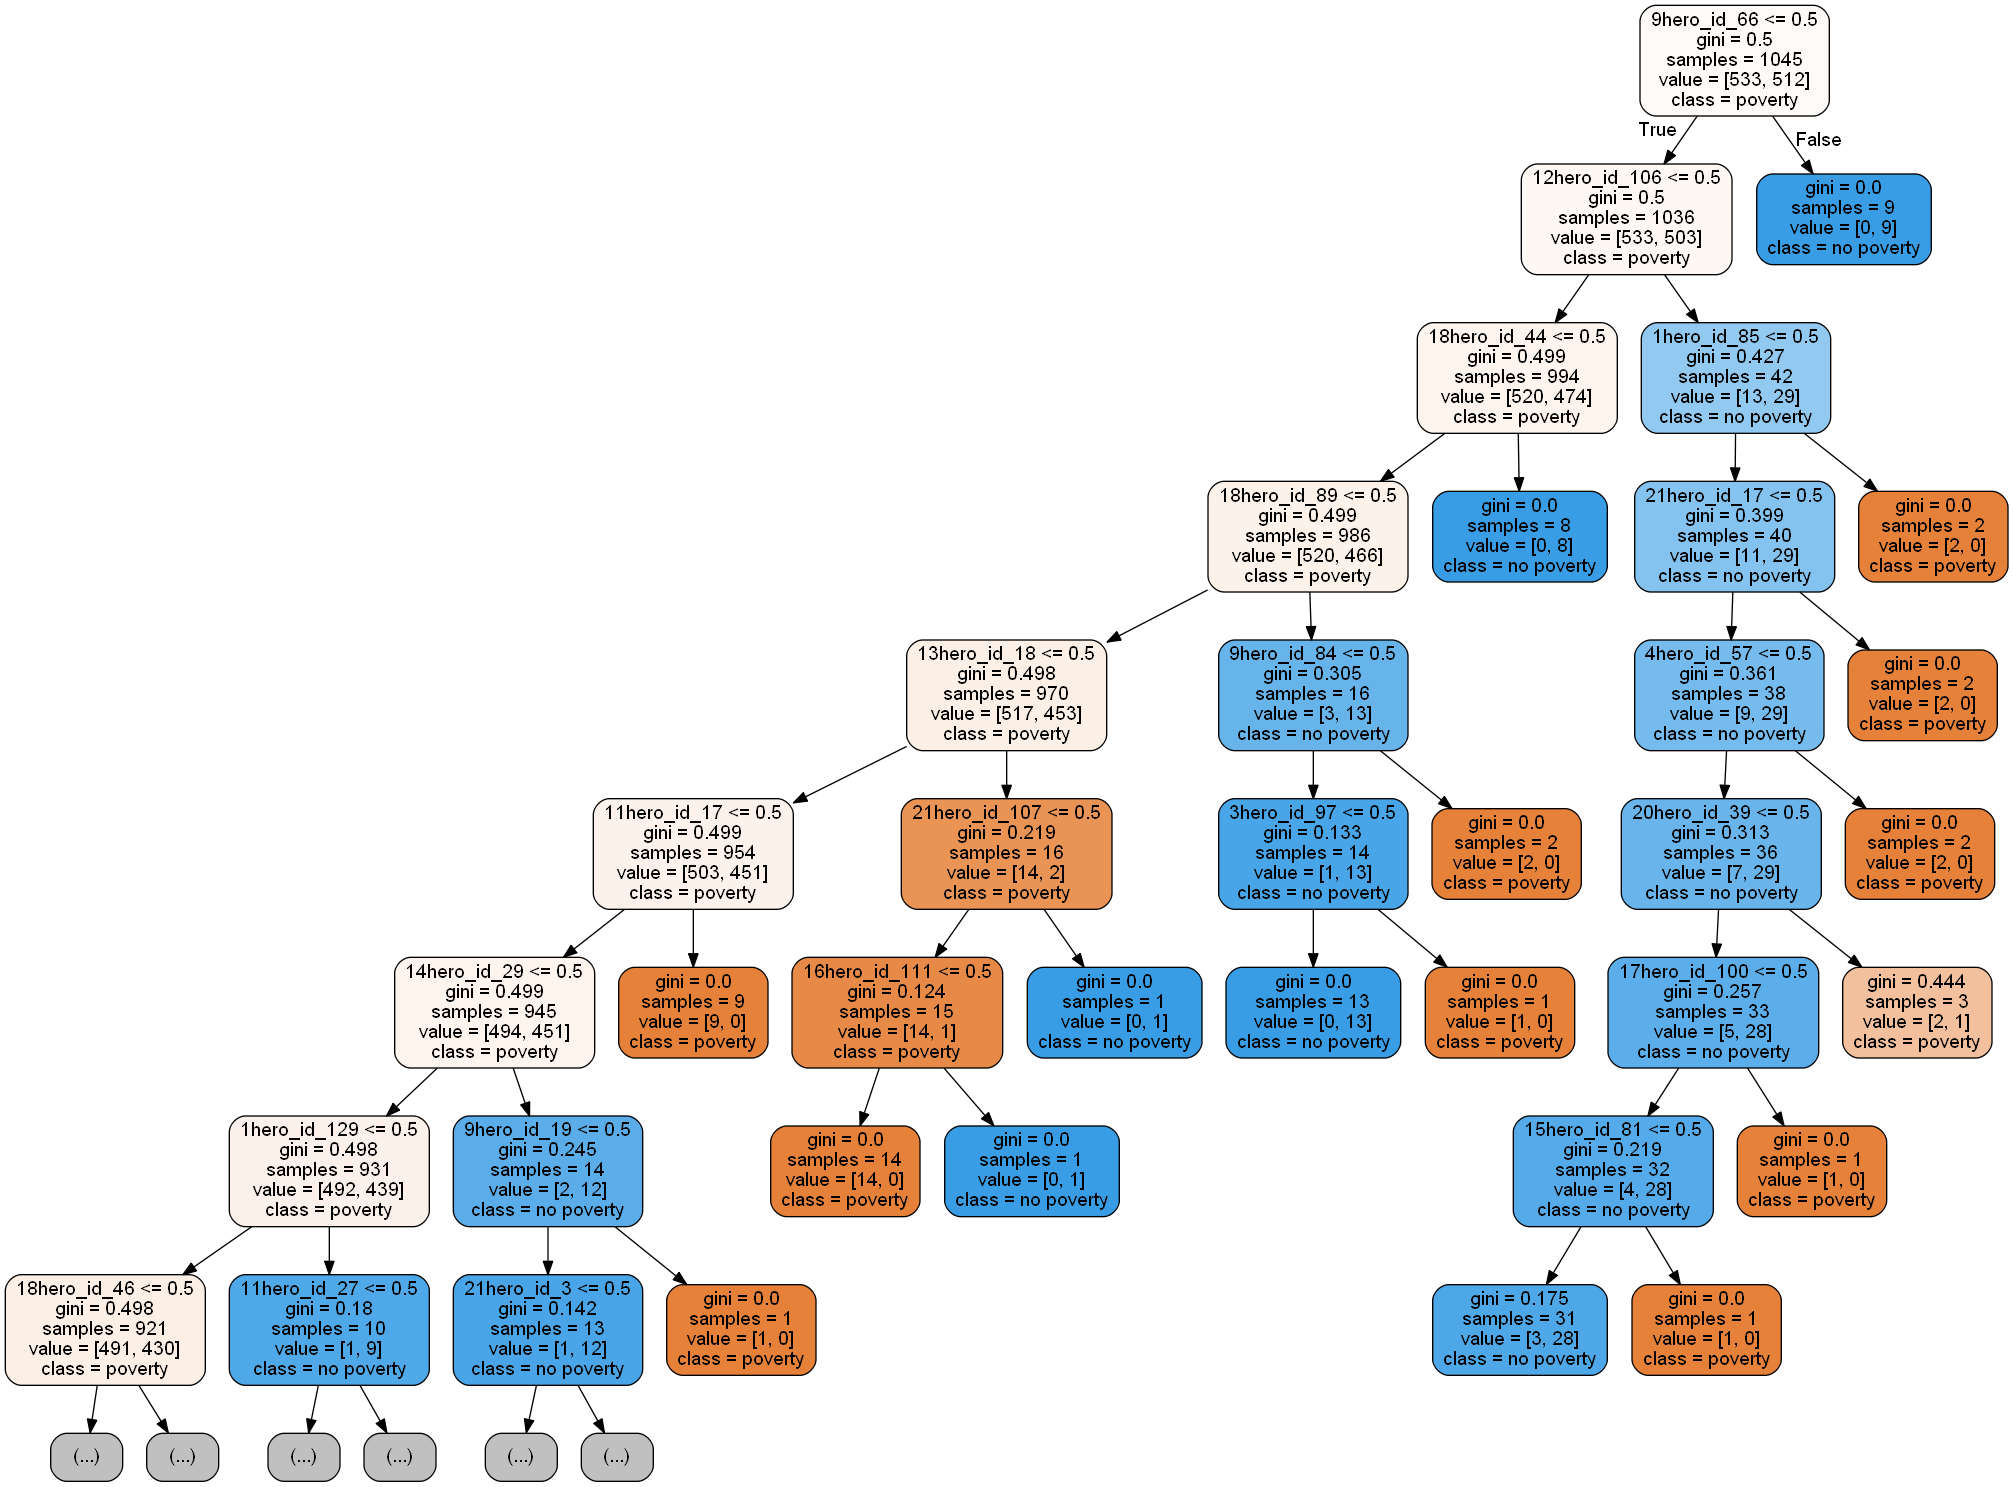

In [51]:
from IPython.display import Image
Image('tree_from_optimized_forest.png')

## Model with Hot Encoding

## Setup Model 

For the first pass, let's try the Random Forest model with the entire training set (i.e., will not split training data)

Fitting the random forest model to the training set. Checking performance as we adjust the number of trees. 

In [14]:
%%time 
from sklearn.ensemble import RandomForestClassifier

estimator_number = list(range(1,1001,10))
train_scores = []
test_scores= []

for i in estimator_number:
    rfc = RandomForestClassifier(n_estimators=i, n_jobs=-1, random_state=17) # n_jobs refers to number of processors to use 
    rfc.fit(X_train, y_train)
    
    train_score = rfc.score(X_train, y_train) 
    test_score = rfc.score(X_valid, y_valid)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    if (i % 9== 0):
        print(f'tried {i} estimators')

tried 81 estimators
tried 171 estimators
tried 261 estimators
tried 351 estimators
tried 441 estimators
tried 531 estimators
tried 621 estimators
tried 711 estimators
tried 801 estimators
tried 891 estimators
tried 981 estimators
Wall time: 3min 31s


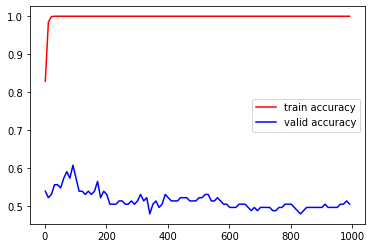

In [24]:
plt.figure()
plt.plot(estimator_number, train_scores, c='red', label='train accuracy')
plt.plot(estimator_number, test_scores, c='blue', label='valid accuracy')
plt.legend()
plt.show()

Model 
10 estimators

Hmmm... looks like 10 estimators is best we really need 

In [22]:
# Try this once with 10 estimators 

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, max_depth=None, random_state=17)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [23]:
# https://www.kaggle.com/kashnitsky/dota-2-win-prediction-random-forest-starter
y_pred = model.predict_proba(X_test)[:, 1]

In [24]:
y_pred

array([0.6       , 0.8       , 0.8       , 0.9       , 0.1       ,
       0.5       , 0.2       , 0.7       , 0.4       , 0.5       ,
       0.8       , 0.7       , 0.3       , 0.7       , 0.7       ,
       0.4       , 0.5       , 0.6       , 0.8       , 0.6       ,
       0.5       , 0.2       , 0.6       , 0.5       , 0.5       ,
       0.7       , 0.4       , 0.4       , 0.5       , 0.7       ,
       0.4       , 0.6       , 0.3       , 0.6       , 0.8       ,
       0.4       , 0.6       , 0.8       , 0.4       , 0.9       ,
       0.5       , 0.3       , 0.6       , 0.5       , 0.6       ,
       0.7       , 0.5       , 0.9       , 0.36666667, 0.7       ,
       0.4       , 0.4       , 0.4       , 0.6       , 0.1       ,
       0.7       , 0.2       , 0.9       , 0.6       , 0.6       ,
       0.4       , 0.5       , 0.3       , 0.4       , 0.4       ,
       0.2       , 0.2       , 0.5       , 0.8       , 0.6       ,
       0.        , 0.8       , 0.6       , 0.4       , 0.6    

In [25]:
from sklearn.metrics import roc_auc_score

test_score = roc_auc_score(y_test, y_pred)
print('Validation ROC-AUC score:', test_score)

Validation ROC-AUC score: 0.5789241622574957


In [26]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred > 0.5)
print('Validation accuracy of P>0.5 classifier:', test_accuracy)

Validation accuracy of P>0.5 classifier: 0.6153846153846154


try running cross validation on just the training set (still reserving validation set) see if training set is large enough to pull this off. Otherwise, will need to perform cross validatin on entire remainder set 

In [27]:
from sklearn.model_selection import ShuffleSplit, KFold, cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=17)

In [29]:
%%time

model_rf1 = RandomForestClassifier(n_estimators=10, n_jobs=-1,
                                   max_depth=None, random_state=17)

# calcuate ROC-AUC for each split
cv_scores_rf1 = cross_val_score(model_rf1, X_train, y_train, cv=cv, scoring='roc_auc')

Wall time: 2.49 s


In [30]:
%%time

model_rf2 = RandomForestClassifier(n_estimators=10, n_jobs=-1,
                                   min_samples_leaf=3, random_state=17)

cv_scores_rf2 = cross_val_score(model_rf2, X_train, y_train, cv=cv, 
                                scoring='roc_auc', n_jobs=-1)

Wall time: 409 ms


In [31]:
cv_scores_rf1

array([0.50352444, 0.4775    , 0.42931818, 0.50226449, 0.46125908])

In [32]:
cv_scores_rf2

array([0.5075188 , 0.51681818, 0.47272727, 0.52536232, 0.44891041])

In [33]:
print('Model 1 mean score:', cv_scores_rf1.mean())
print('Model 2 mean score:', cv_scores_rf2.mean())

Model 1 mean score: 0.4747732381130357
Model 2 mean score: 0.49426739640015827


Second model seems to be favoured here, and is returns better cv score in 4/5 folds 

In [34]:
cv_scores_rf2 > cv_scores_rf1

array([ True,  True,  True,  True, False])

In [40]:
model_rf2_tuned = RandomForestClassifier(n_estimators=10, n_jobs=-14, random_state=17)
model_rf2_tuned.fit(X_remainder, y_remainder)
df_submission_base = pd.DataFrame(
    {'radiant_win_prob': model_rf2_tuned.predict_proba(X_test)[:, 1]}, 
    index=test_features.index,
)

In [42]:
#df_submission_base

In [43]:
y_pred = model.predict_proba(X_test)[:, 1]
test_score = roc_auc_score(y_test, y_pred)
print('Validation ROC-AUC score:', test_score)
test_accuracy = accuracy_score(y_test, y_pred > 0.5)
print('Validation accuracy of P>0.5 classifier:', test_accuracy)

Validation ROC-AUC score: 0.5789241622574957
Validation accuracy of P>0.5 classifier: 0.6153846153846154


In [45]:
train_rf_predictions = model_rf2_tuned.predict(X_train)
train_rf_probs = model_rf2_tuned.predict_proba(X_train)[:, 1]

rf_predictions = model_rf2_tuned.predict(X_test)
rf_probs = model_rf2_tuned.predict_proba(X_test)[:, 1]

In [47]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

In [ ]:
# SOURCE: https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb
def evaluate_model(predictions, probs, train_predictions, train_probs):    
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_test, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [46]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

NameError: name 'evaluate_model' is not defined

Model 
100 estimators

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size = 0.1, random_state = SEED) ## see top, SEED = 17

In [17]:
%%time
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
model.fit(X_train, y_train)

Wall time: 461 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [18]:
y_pred = model.predict_proba(X_valid)[:, 1]

In [19]:
y_pred

array([0.475 , 0.47  , 0.63  , 0.42  , 0.57  , 0.57  , 0.51  , 0.36  ,
       0.55  , 0.76  , 0.57  , 0.5   , 0.64  , 0.53  , 0.37  , 0.46  ,
       0.56  , 0.58  , 0.63  , 0.39  , 0.365 , 0.53  , 0.56  , 0.52  ,
       0.52  , 0.6   , 0.32  , 0.7   , 0.39  , 0.43  , 0.56  , 0.52  ,
       0.46  , 0.4425, 0.56  , 0.3   , 0.37  , 0.5   , 0.68  , 0.35  ,
       0.45  , 0.47  , 0.53  , 0.57  , 0.55  , 0.69  , 0.41  , 0.73  ,
       0.53  , 0.51  , 0.55  , 0.56  , 0.55  , 0.35  , 0.54  , 0.54  ,
       0.44  , 0.38  , 0.21  , 0.53  , 0.71  , 0.62  , 0.85  , 0.69  ,
       0.67  , 0.54  , 0.54  , 0.51  , 0.42  , 0.44  , 0.44  , 0.62  ,
       0.54  , 0.36  , 0.56  , 0.75  , 0.28  , 0.36  , 0.75  , 0.49  ,
       0.33  , 0.66  , 0.63  , 0.41  , 0.3625, 0.5   , 0.63  , 0.63  ,
       0.59  , 0.44  , 0.54  , 0.32  , 0.47  , 0.44  , 0.27  , 0.59  ,
       0.56  , 0.44  , 0.52  , 0.6   , 0.5   , 0.59  , 0.47  , 0.36  ,
       0.31  ])

In [20]:
valid_score = roc_auc_score(y_valid, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.38025055268975677


In [21]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print('Validation accuracy of P>0.5 classifier:', valid_accuracy)

Validation accuracy of P>0.5 classifier: 0.38095238095238093


Hmmm... looks like 10 estimators is best we really need 

In [12]:
# Try this once with 10 estimators 

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, max_depth=None, random_state=17)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [14]:
# https://www.kaggle.com/kashnitsky/dota-2-win-prediction-random-forest-starter
y_pred = model.predict_proba(X_test)[:, 1]

In [15]:
y_pred

array([0.4 , 0.5 , 0.5 , 0.7 , 0.3 , 0.5 , 0.5 , 0.4 , 0.5 , 0.1 , 0.2 ,
       0.4 , 0.7 , 0.5 , 0.55, 0.8 , 0.6 , 0.6 , 0.4 , 0.4 , 0.6 , 0.3 ,
       0.7 , 0.5 , 0.5 , 0.6 , 0.5 , 0.5 , 0.5 , 0.2 , 0.4 , 0.7 , 0.4 ,
       0.4 , 0.5 , 0.2 , 0.3 , 0.3 , 0.3 , 0.7 , 0.7 , 0.7 , 0.4 , 0.6 ,
       0.5 , 0.9 , 0.3 , 0.6 , 0.3 , 0.4 , 0.4 , 0.4 , 0.6 , 0.3 , 0.4 ,
       0.3 , 0.4 , 0.5 , 0.8 , 0.4 , 0.4 , 0.5 , 0.3 , 0.7 , 0.2 , 0.2 ,
       0.5 , 0.3 , 0.6 , 0.8 , 0.5 , 0.4 , 0.3 , 0.5 , 0.6 , 0.5 , 0.6 ,
       0.4 , 0.4 , 0.2 , 0.4 , 0.4 , 0.6 , 0.5 , 0.4 , 0.4 , 0.8 , 0.4 ,
       0.6 , 0.8 , 0.3 , 0.4 , 0.7 , 0.4 , 0.4 , 0.5 , 0.6 , 0.6 , 0.5 ,
       0.5 , 0.5 , 0.3 , 0.3 , 0.5 , 0.8 , 0.8 , 0.5 , 0.8 , 0.3 , 0.6 ,
       0.5 , 0.6 , 0.7 , 0.8 , 0.3 , 0.1 , 0.6 ])

In [16]:
from sklearn.metrics import roc_auc_score

test_score = roc_auc_score(y_test, y_pred)
print('Validation ROC-AUC score:', test_score)

Validation ROC-AUC score: 0.5655496766607878


In [18]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred > 0.5)
print('Validation accuracy of P>0.5 classifier:', test_accuracy)

Validation accuracy of P>0.5 classifier: 0.5726495726495726


In [20]:
from xgboost import XGBClassifier

XGB_model = XGBClassifier(n_jobs=-1, random_state=17 )
XGB_model.fit(X_train, y_train)
print(f"XG Boost score: {XGB_model.score(X_test, y_test)}")

XG Boost score: 0.5128205128205128


In [23]:
# https://www.kaggle.com/vladislavkisin/dota-2-new-approaches-model-comparison-json
#Count CV scoring and houldout scoring: 
holdout_score_1 = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])
print('Holdout score: ', holdout_score_1)

Holdout score:  0.47310243183493006


In [ ]:
cv_score_1 = cross_val_score(model, full_df_mod[:idx_split], y_train, cv=cv, scoring = 'roc_auc') 

In [ ]:
# https://www.kaggle.com/vladislavkisin/dota-2-new-approaches-model-comparison-json
#New results.
print('CV scores: ', cv_score_1)
print('CV mean: ', cv_score_1.mean())
print('CV std:', cv_score_1.std())
print('Holdout score: ', holdout_score_1)
print('Better results on CV: ', cv_score_1>cv_score)